Pre-treatment data size before filtering: (480, 18)
Pre-treatment data size after filtering: (479, 18)
Post-treatment data size before filtering: (480, 18)
Post-treatment data size after filtering: (477, 18)
Weighted Pre-Treatment Speed: 16.38 mph
Weighted Post-Treatment Speed: 14.13 mph
T-Statistic: 44.221, P-Value: 0.000


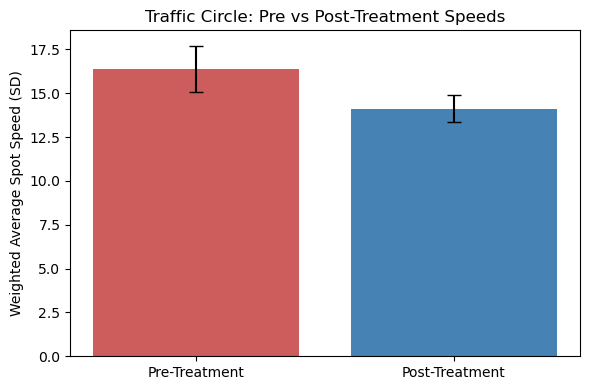

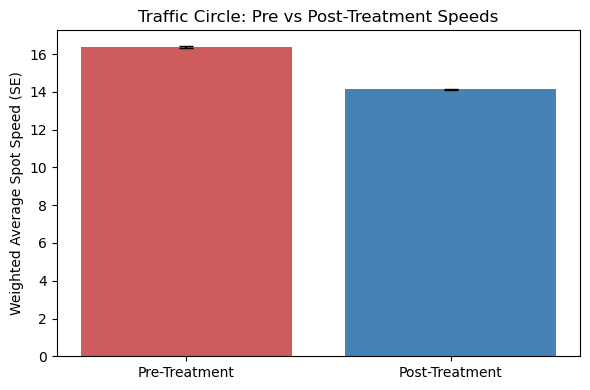

Highest Pre-Treatment 85th Percentile: 28.0 mph
Highest Post-Treatment 85th Percentile: 26.0 mph
                    Data Periods                          Mode of Travel  \
385  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
349  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
367  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
373  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
265  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
409  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
427  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
230  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
356  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   
391  Jun 01, 2021 - Jun 01, 2022  All Vehicles - StL All Vehicles Volume   

     Zone ID      Zone Name Zone Is Pass-Through  Zone Direction (

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

pre_treatment = pd.read_csv('data/Ave_50_pre.csv')
post_treatment = pd.read_csv('data/Ave_50_post.csv')

# Remove 'All Days' and 'All Day' rows
pre_treatment = pre_treatment[
    (pre_treatment['Day Type'] != '0: All Days (M-Su)') & 
    (pre_treatment['Day Part'] != '0: All Day (12am-12am)')
]
post_treatment = post_treatment[
    (post_treatment['Day Type'] != '0: All Days (M-Su)') & 
    (post_treatment['Day Part'] != '0: All Day (12am-12am)')
]

# Outlier filter function
def filter_outliers(df, column, threshold=3):
    valid_values = df[column].dropna()
    z_scores = stats.zscore(valid_values)
    valid_indices = valid_values.index[np.abs(z_scores) < threshold]
    return df.loc[valid_indices]

# Filter outliers in 95th percentile
pre_treatment_filtered = filter_outliers(pre_treatment, '95th Speed Percentile')
post_treatment_filtered = filter_outliers(post_treatment, '95th Speed Percentile')

print("Pre-treatment data size before filtering:", pre_treatment.shape)
print("Pre-treatment data size after filtering:", pre_treatment_filtered.shape)
print("Post-treatment data size before filtering:", post_treatment.shape)
print("Post-treatment data size after filtering:", post_treatment_filtered.shape)

# Speed and volume columns
pre_speeds = pre_treatment_filtered['Avg Spot Speed (mph)']
post_speeds = post_treatment_filtered['Avg Spot Speed (mph)']
pre_volume = pre_treatment_filtered['Average Daily Spot Traffic (StL Volume)']
post_volume = post_treatment_filtered['Average Daily Spot Traffic (StL Volume)']

# Weighted average speed
pre_weighted_speed = (pre_speeds * pre_volume).sum() / pre_volume.sum()
post_weighted_speed = (post_speeds * post_volume).sum() / post_volume.sum()

# Weighted standard deviation and error
def weighted_std(values, weights):
    mean = (values * weights).sum() / weights.sum()
    variance = (weights * (values - mean) ** 2).sum() / weights.sum()
    return variance ** 0.5

pre_weighted_std = weighted_std(pre_speeds, pre_volume)
post_weighted_std = weighted_std(post_speeds, post_volume)
pre_weighted_se = pre_weighted_std / np.sqrt(len(pre_speeds))
post_weighted_se = post_weighted_std / np.sqrt(len(post_speeds))

# T-test
valid_indices = pre_speeds.notna() & post_speeds.notna()
t_stat, p_value = stats.ttest_rel(pre_speeds[valid_indices], post_speeds[valid_indices])

print(f"Weighted Pre-Treatment Speed: {pre_weighted_speed:.2f} mph")
print(f"Weighted Post-Treatment Speed: {post_weighted_speed:.2f} mph")
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3f}")

# Bar charts
bar_colors = ['indianred', 'steelblue']
plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_std, post_weighted_std], capsize=5, color=bar_colors)
plt.ylabel('Weighted Average Spot Speed (SD)')
plt.title('Traffic Circle: Pre vs Post-Treatment Speeds')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Pre-Treatment', 'Post-Treatment'], 
        [pre_weighted_speed, post_weighted_speed], 
        yerr=[pre_weighted_se, post_weighted_se], capsize=5, color=bar_colors)
plt.ylabel('Weighted Average Spot Speed (SE)')
plt.title('Traffic Circle: Pre vs Post-Treatment Speeds')
plt.tight_layout()
plt.show()

# Max 85th percentile speed rows
max_85th_speed_row_pre = pre_treatment_filtered.loc[pre_treatment_filtered['85th Speed Percentile'].idxmax()]
max_85th_speed_row_post = post_treatment_filtered.loc[post_treatment_filtered['85th Speed Percentile'].idxmax()]

max_85th_speed_value_pre = max_85th_speed_row_pre['85th Speed Percentile']
max_85th_speed_value_post = max_85th_speed_row_post['85th Speed Percentile']

print(f"Highest Pre-Treatment 85th Percentile: {max_85th_speed_value_pre} mph")
print(f"Highest Post-Treatment 85th Percentile: {max_85th_speed_value_post} mph")

# Show top 10 pre-treatment high-speed observations
top_speed = pre_treatment.sort_values('95th Speed Percentile', ascending=False).head(10)
print(top_speed)


In [2]:
pre_weighted_85th_speed = (pre_treatment['85th Speed Percentile'] * pre_volume).sum() / pre_volume.sum()
post_weighted_85th_speed = (post_treatment['85th Speed Percentile'] * post_volume).sum() / post_volume.sum()

pre_weighted_95th_speed = (pre_treatment['95th Speed Percentile'] * pre_volume).sum() / pre_volume.sum()
post_weighted_95th_speed = (post_treatment['95th Speed Percentile'] * post_volume).sum() / post_volume.sum()

print(f"Weighted Pre-Treatment 85th Speed Percentile: {pre_weighted_85th_speed:.2f} mph")
print(f"Weighted Post-Treatment 85th Speed Percentile: {post_weighted_85th_speed:.2f} mph")
print(f"Weighted Pre-Treatment 95th Speed Percentile: {pre_weighted_95th_speed:.2f} mph")
print(f"Weighted Post-Treatment 95th Speed Percentile: {post_weighted_95th_speed:.2f} mph")

max_85th_speed_row_pre = pre_treatment.loc[pre_treatment['85th Speed Percentile'].idxmax()]
max_85th_speed_row_post = post_treatment.loc[post_treatment['85th Speed Percentile'].idxmax()]
max_85th_speed_value_pre = max_85th_speed_row_pre['85th Speed Percentile']
max_85th_speed_value_post = max_85th_speed_row_post['85th Speed Percentile']

max_95th_speed_row_pre = pre_treatment.loc[pre_treatment['95th Speed Percentile'].idxmax()]
max_95th_speed_row_post = post_treatment.loc[post_treatment['95th Speed Percentile'].idxmax()]
max_95th_speed_value_pre = max_95th_speed_row_pre['95th Speed Percentile']
max_95th_speed_value_post = max_95th_speed_row_post['95th Speed Percentile']
print(f"Highest value for pre-treatment'85th Speed Percentile': {max_85th_speed_value_pre} mph",
     f"Highest value for post-treatment'85th Speed Percentile': {max_85th_speed_value_post} mph")
print(f"Highest value for pre-treatment'95th Speed Percentile': {max_95th_speed_value_pre} mph",
     f"Highest value for post-treatment'95th Speed Percentile': {max_95th_speed_value_post} mph")

Weighted Pre-Treatment 85th Speed Percentile: 20.53 mph
Weighted Post-Treatment 85th Speed Percentile: 17.76 mph
Weighted Pre-Treatment 95th Speed Percentile: 24.54 mph
Weighted Post-Treatment 95th Speed Percentile: 21.65 mph
Highest value for pre-treatment'85th Speed Percentile': 28.0 mph Highest value for post-treatment'85th Speed Percentile': 26.0 mph
Highest value for pre-treatment'95th Speed Percentile': 34.0 mph Highest value for post-treatment'95th Speed Percentile': 45.0 mph


In [3]:
filtered_pre = pre_treatment[pre_treatment['Day Type'] != '0: All Days (M-Su)']
filtered_post = post_treatment[post_treatment['Day Type'] != '0: All Days (M-Su)']

total_pre_volume = filtered_pre['Average Daily Spot Traffic (StL Volume)'].sum()
total_post_volume = filtered_post['Average Daily Spot Traffic (StL Volume)'].sum()

total_combined_volume = total_pre_volume + total_post_volume

print(f"Total Pre-Treatment Volume: {total_pre_volume:,.0f}")
print(f"Total Post-Treatment Volume: {total_post_volume:,.0f}")
print(f"Combined Volume (Pre + Post): {total_combined_volume:,.0f}")


Total Pre-Treatment Volume: 159,163
Total Post-Treatment Volume: 113,170
Combined Volume (Pre + Post): 272,333


In [4]:
pre_weighted_85th_speed = (pre_treatment['85th Speed Percentile'] * pre_volume).sum() / pre_volume.sum()
post_weighted_85th_speed = (post_treatment['85th Speed Percentile'] * post_volume).sum() / post_volume.sum()

pre_weighted_95th_speed = (pre_treatment['95th Speed Percentile'] * pre_volume).sum() / pre_volume.sum()
post_weighted_95th_speed = (post_treatment['95th Speed Percentile'] * post_volume).sum() / post_volume.sum()

print(f"Weighted Pre-Treatment 85th Speed Percentile: {pre_weighted_85th_speed:.2f} mph")
print(f"Weighted Post-Treatment 85th Speed Percentile: {post_weighted_85th_speed:.2f} mph")
print(f"Weighted Pre-Treatment 95th Speed Percentile: {pre_weighted_95th_speed:.2f} mph")
print(f"Weighted Post-Treatment 95th Speed Percentile: {post_weighted_95th_speed:.2f} mph")

max_85th_speed_row_pre = pre_treatment.loc[pre_treatment['85th Speed Percentile'].idxmax()]
max_85th_speed_row_post = post_treatment.loc[post_treatment['85th Speed Percentile'].idxmax()]
max_85th_speed_value_pre = max_85th_speed_row_pre['85th Speed Percentile']
max_85th_speed_value_post = max_85th_speed_row_post['85th Speed Percentile']

print(f"Highest value for pre-treatment'85th Speed Percentile': {max_85th_speed_value_pre} mph",
     f"Highest value for post-treatment'85th Speed Percentile': {max_85th_speed_value_post} mph")

Weighted Pre-Treatment 85th Speed Percentile: 20.53 mph
Weighted Post-Treatment 85th Speed Percentile: 17.76 mph
Weighted Pre-Treatment 95th Speed Percentile: 24.54 mph
Weighted Post-Treatment 95th Speed Percentile: 21.65 mph
Highest value for pre-treatment'85th Speed Percentile': 28.0 mph Highest value for post-treatment'85th Speed Percentile': 26.0 mph


In [6]:
pre_dates = filtered_pre['Data Periods']
post_dates = filtered_post['Data Periods']
pre_treatment['Pre_Date'] = pre_dates
post_treatment['Pre_Date'] = post_dates


In [8]:
results = {
    'Intersection': 'Avenue 50 & Meridian St',
    'Pre_Mean': float(pre_weighted_speed),
    'Post_Mean': float(post_weighted_speed),
    'Pre_Std': float(pre_weighted_std),
    'Post_Std': float(post_weighted_std),
    'Pre_SE': float(pre_weighted_se),
    'Post_SE': float(post_weighted_se),
    'Pre_85th': float(pre_weighted_85th_speed),
    'Post_85th': float(post_weighted_85th_speed),
    'Pre_95th': float(pre_weighted_95th_speed),
    'Post_95th': float(post_weighted_95th_speed),
    'Pre_Max_85th': float(max_85th_speed_value_pre),
    'Post_Max_85th': float(max_85th_speed_value_post),
    'T_Statistic': float(t_stat),
    'P_Value': float(p_value),
    'Pre_Volume': int(total_pre_volume),
    'Post_Volume': int(total_post_volume),
    'Combined Volume': int(total_combined_volume),
    'Pre_Treatment_Volume': int(total_pre_volume),
    'Post_Treatment_Volume': int(total_post_volume),
    'Combined_Volumne': int(total_combined_volume),
    'Pre_Date': str(pre_dates.unique()),
    'Post_Date': str(post_dates.unique())

}

import json
with open('../results/Avenue 50 & Meridian St_summary.json', 'w') as f:
    json.dump(results, f)